# NLP: Text Classification Using the Bag-of-Words Model

In this notebook, we demonstrate the essential steps for performing text classification using a machine learning (ML) model, specifically illustrating the Logistic Regression model.

## Dataset

We utilize a corpus of emails to classify them into one of two categories: spam and non-spam (ham). The dataset comprises labeled emails, with ham represented by label 0 and spam by label 1.

You can access the dataset here: [Spam Filter Dataset on Kaggle](https://www.kaggle.com/karthickveerakumar/spam-filter).

## Steps for Classification

The following are the general steps in Natural Language Processing (NLP) for performing classification using an ML model:

1. **Exploratory Data Analysis**
2. **Feature Extraction**
   - a. Text Standardization
   - b. Text Preprocessing (Tokenization, removing stop words, etc.)
   - c. Vocabulary Construction and Indexing
   - d. Vectorization of Features using the Bag-of-Words (BoW) Model
3. **Feature Scaling** (required by some models)
4. **Model Selection**
5. **Training the Optimal Model**
6. **Evaluating the Model on Test Data**

In [1]:
import numpy as np
import pandas as pd
import warnings

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import nltk
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

/var/folders/zd/2ty0m0yn1jzc2zjgq1154kkxxmbbr2/T/ipykernel_38629/436574774.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package wordnet to /Users/mhasan2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load Data

Load data from the CSV file as a Pandas DataFrame object.

In [2]:
df = pd.read_csv('/Users/mhasan2/Library/CloudStorage/OneDrive-UniversityofNebraska-Lincoln/Datasets/emails.csv')

#  1. Exploratory Data Analysis

## Quick Check of the Data

Let’s take a look at the top five rows using the DataFrame’s head() method.

In [3]:
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


## Get Information on the Pandas DataFrame Object

Use Pandas info method to print information about a DataFrame including the index dtype and columns, non-null values and memory usage.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


## Check if there are any null values in any columns

In [5]:
df.isna().values.any()

False

## Observation: NaN Values

We observe that there are no missing values (i.e., NaN values) in the DataFrame object.

If there exists any NaN values in the "text" column, we should remove the rows containing NaN values using the following method.

df = df[df['text'].notna()]

## Dimension of the Data

In [6]:
print("Dimension of the data: ", df.shape)

no_of_rows = df.shape[0]
no_of_columns = df.shape[1]

print("\nNo. of Rows: %d" % no_of_rows)
print("No. of Columns: %d" % no_of_columns)

Dimension of the data:  (5728, 2)

No. of Rows: 5728
No. of Columns: 2


## Class Distribution

In [7]:
df.groupby('spam').count()

,text
spam,
0,4360
1,1368


## Visualization of the Class Distribution

In [10]:
label_counts = df.spam.value_counts()
print(label_counts)

spam
0    4360
1    1368
Name: count, dtype: int64


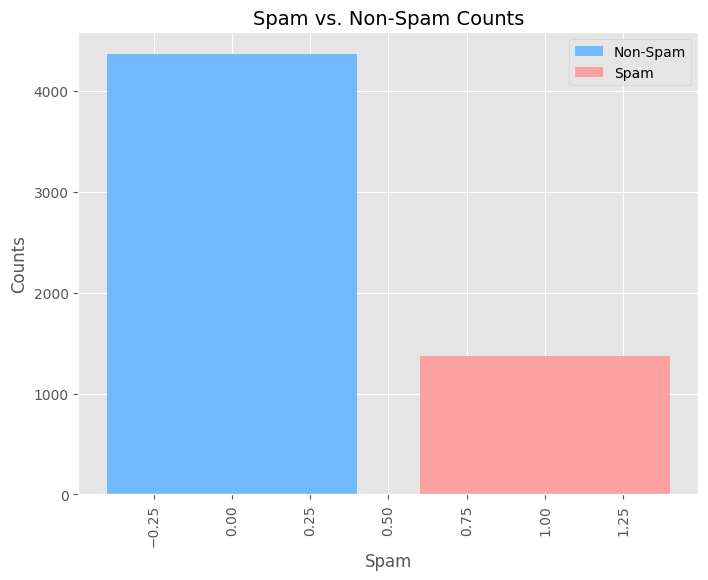

In [16]:
label_counts = df.spam.value_counts()

plt.figure(figsize=(8, 6))

# Plot for non-spam (label = 0)
plt.bar(label_counts.index[0], label_counts.values[0], color='#66B3FF', alpha=0.9, label='Non-Spam')

# Plot for spam (label = 1)
plt.bar(label_counts.index[1], label_counts.values[1], color='#FF9999', alpha=0.9, label='Spam')

plt.xticks(rotation='vertical')
plt.xlabel('Spam', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Spam vs. Non-Spam Counts', fontsize=14)  # Optional title
plt.legend()  # Show legend
plt.show()


## Correlation Between the Email length & the Class (Ham/Spam)

We need to check whether the length of the emails are correlated to their classes (ham/spam).

In [17]:
# Create a new column "length" that stores the length of the text on each row
df['length'] = df['text'].map(lambda text: len(text))

df.groupby('spam').length.describe()

,count,mean,std,min,25%,50%,75%,max
spam,,,,,,,,
0,4360.0,1631.918119,1959.664549,13.0,577.75,1122.0,2037.25,43952.0
1,1368.0,1317.257310,2271.372893,18.0,401.50,693.5,1250.25,28432.0


## Visualize Length Distribution by Class

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

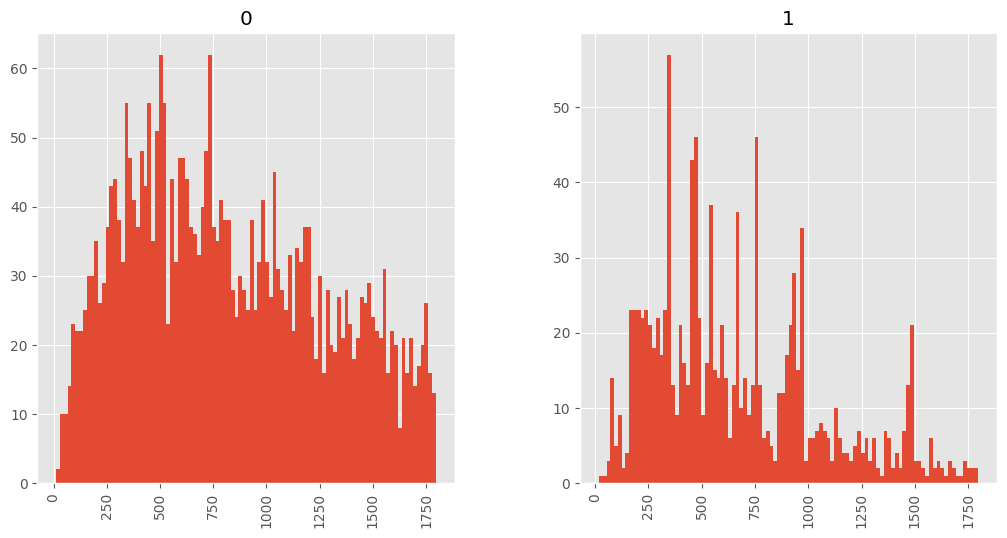

In [18]:
# Use a length threshold to visualize the distribution of length per class

threshold = 1800
emails_subset = df[df.length < threshold]
emails_subset.hist(column='length', by='spam', bins=100, figsize=(12, 6))

## Observation from the EDA

We observe that **only 23.88%** emails are spam.

Also, there are some outliers (long emails).

# 2. Feature Extraction 

## a) Text Standardization through Lemmatization

Text standardization techniques, such as stemming and lemmatization, play a crucial role in Natural Language Processing (NLP) by preparing text, words, and documents for further analysis.

Among these techniques, lemmatization is particularly well-suited for text classification tasks. It involves grouping together the inflected forms of a word, allowing them to be analyzed as a single item represented by the word's lemma, or dictionary form. This process not only reduces the complexity of the text but also preserves the contextual meaning of words, making it an effective choice for improving the accuracy of classification models.


In [19]:
%%time
lemmatizer = WordNetLemmatizer()

df['text_lemmatized'] = df['text'].map(lambda text: ' '.join(lemmatizer.lemmatize(w) for w in nltk.word_tokenize(text.lower())))

CPU times: user 6.57 s, sys: 45.4 ms, total: 6.61 s
Wall time: 6.62 s


## Observe a Random Document Before and After Normalization

In [20]:
print("\nEmail (no lemmatization):\n")
print(df['text'][171])
print("\nLemmatized Email:\n")
print(df['text_lemmatized'][171])


Email (no lemmatization):

Subject: failure notice  hi . this is the qmail - send program at nsl . mxlinux 2 . com .  i ' m afraid i wasn ' t able to deliver your message to the following addresses .  this is a permanent error ; i ' ve given up . sorry it didn ' t work out .  :  this address no longer accepts mail .  - - - below this line is a copy of the message .  return - path :  received : ( qmail 30891 invoked from network ) ; 19 jul 2005 10 : 57 : 17 - 0000  received : from ntokymo 09176 . okym . nt . adsl . ppp . infoweb . ne . jp ( helo mailwisconsin . com ) ( 218 . 229 . 92 . 176 )  by wpc 2010 . amenworld . com with smtp ; 19 jul 2005 10 : 57 : 17 - 0000  received : from 205 . 214 . 42 . 66  ( squirrelmail authenticated user projecthoneypot @ projecthoneypot . org ) ;  by mailwisconsin . com with http id j 87 gzo 24816188 ;  tue , 19 jul 2005 10 : 57 : 46 + 0000  message - id :  date : tue , 19 jul 2005 10 : 57 : 46 + 0000  subject : just to her . . .  from : " barry castill

## Generate Wordcloud of the Spam Emails

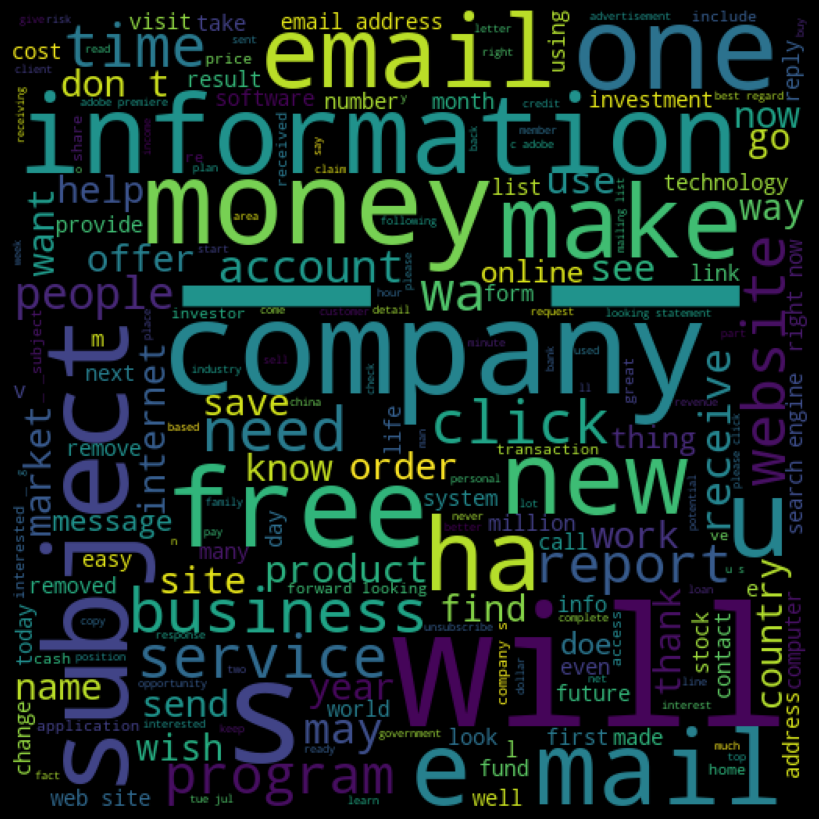

In [21]:
spam_words = ''.join(list(df[df['spam']==1]['text_lemmatized']))
spam_wordclod = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wordclod)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

## Generate Wordcloud of the Ham Emails

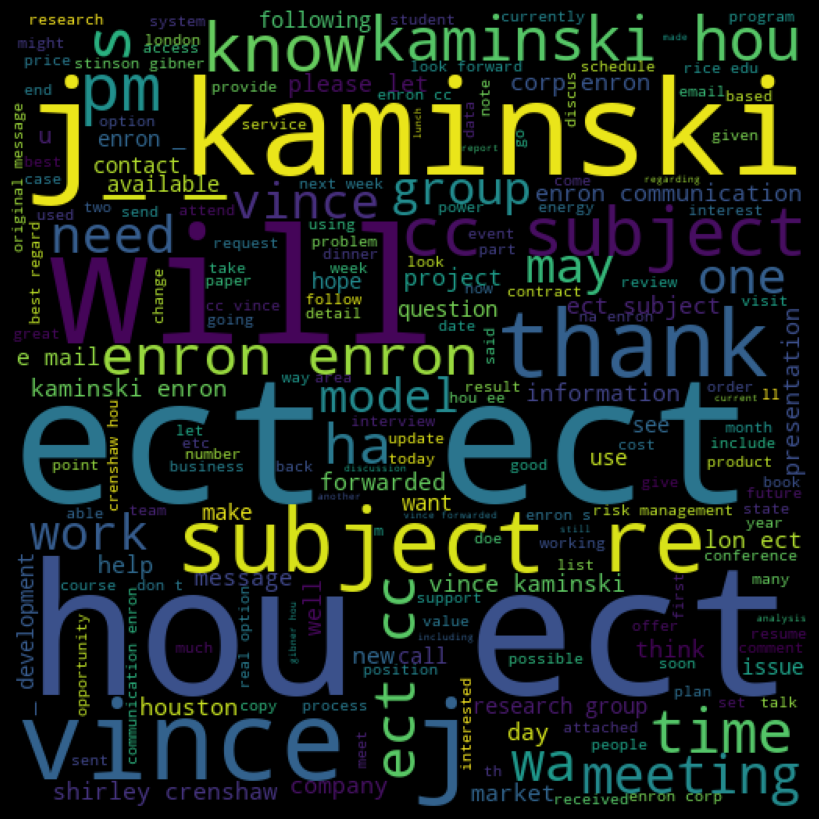

In [22]:
spam_words = ''.join(list(df[df['spam']==0]['text_lemmatized']))
spam_wordclod = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wordclod)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

## Create a Separate Feature Set (Data Matrix X) and Target Array (1D Array y)

In this step, we will create a data matrix \( X \) that contains all the features, along with a 1D target array \( y \) that holds the corresponding target values.

First, we will create separate DataFrame objects for \( X \) and \( y \). Next, we will convert these DataFrame objects into arrays to facilitate further processing.



In [23]:
X = df["text_lemmatized"] # DataFrame containing the target 
y = df['spam'] # DataFrame containing the features excluding the target

'''
Convert X & y into Arrays
Use the NumPy asarray() method to convert the Pandas data frame object X and y into numpy arrays.
'''

X = np.asarray(X) # Data Matrix containing all features excluding the target
y = np.asarray(y) # 1D target array

print("Data Matrix (X) Shape: ", X.shape)
print("Label array (y) Shape: ", y.shape)

print("\nData Matrix (X) Type: ", X.dtype)
print("Label array (y) Type: ", y.dtype)

# Read a random "email" from X
print("\nA random email:\n")
print(X[0])

Data Matrix (X) Shape:  (5728,)
Label array (y) Shape:  (5728,)

Data Matrix (X) Type:  object
Label array (y) Type:  int64

A random email:

subject : naturally irresistible your corporate identity lt is really hard to recollect a company : the market is full of suqgestions and the information isoverwhelminq ; but a good catchy logo , stylish statlonery and outstanding website will make the task much easier . we do not promise that havinq ordered a iogo your company will automaticaily become a world ieader : it isguite ciear that without good product , effective business organization and practicable aim it will be hotat nowadays market ; but we do promise that your marketing effort will become much more effective . here is the list of clear benefit : creativeness : hand - made , original logo , specially done to reflect your distinctive company image . convenience : logo and stationery are provided in all format ; easy - to - use content management system letsyou change your website c

## Create Train and Test Datasets

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2(b) & 2(c). 2(b) & 2(c). Text Preprocessing and Bag-of-Words Feature Vectorization

The following Scikit-Learn classes are utilized for both text preprocessing (including tokenization and stop word removal) and feature vectorization. These classes implement the Bag-of-Words (BoW) model to convert a collection of text documents into a matrix of token counts:

- **CountVectorizer()**: Converts tokens into their binary or frequency counts.
- **TfidfVectorizer()**: Converts tokens into their Term Frequency-Inverse Document Frequency (TF-IDF) counts.

Both classes can also handle text preprocessing tasks, such as removing stop words. To enable this feature, simply set the `stop_words` attribute of the CountVectorizer or TfidfVectorizer object to `'english'`.

When using the CountVectorizer() class, tokens can be vectorized in two ways:

- **Binary Counts**: This method assigns a count of 1 if a token appears in a document and 0 otherwise. To activate this, set the `binary` attribute of CountVectorizer to `True`.
- **Frequency Counts**: This method counts the number of times each token appears in a document, which is the default setting of the CountVectorizer() class.

Below, we provide code examples demonstrating the use of the CountVectorizer() class for both binary and frequency counts, as well as the TfidfVectorizer() class for TF-IDF counts.

## Using CountVectorizer() for BoW Feature Vectorization

In [25]:
%%time


'''
Create a CountVectorizer object using one of the following two techniques. 
Each technique activates the stop word removal attribute, which can be disabled if desired. 
Please uncomment one of the techniques to use it while commenting out the other.
'''

# count_vect = CountVectorizer(binary=True, stop_words='english')  # Uses binary counts for vectorization
count_vect = CountVectorizer(stop_words='english')  # Uses frequency counts for vectorization



'''
Using the CountVectorizer object, create a matrix representation of the training documents
Each row represents a single document
Each column represents the binary count for each feature
'''
X_train_count_vectorized_features = count_vect.fit_transform(X_train).todense()

print("\nCount Vectorized Training Data Matrix Dimension: ", X_train_count_vectorized_features.shape)
print("\nSize of Vocabulary: ", len(count_vect.vocabulary_))


# Using the CountVectorizer object, create a matrix representation of the test documents
X_test_count_vectorized_features = count_vect.transform(X_test).todense()
print("\nCount Vectorized Test Data Matrix Dimension: ", X_test_count_vectorized_features.shape)


# Convert the feature matrices into numpy ndarrays
X_train_count_vectorized_features = np.asarray(X_train_count_vectorized_features) 
X_test_count_vectorized_features = np.asarray(X_test_count_vectorized_features) 


Count Vectorized Training Data Matrix Dimension:  (4582, 31088)

Size of Vocabulary:  31088

Count Vectorized Test Data Matrix Dimension:  (1146, 31088)
CPU times: user 328 ms, sys: 61.1 ms, total: 389 ms
Wall time: 386 ms


## 3. Scale the Features

In [26]:
scaler = StandardScaler()

# Fit on the training set only
scaler.fit(X_train_count_vectorized_features)

# Apply transform to both the training set and the test set
X_train_count_vectorized_features = scaler.transform(X_train_count_vectorized_features)
X_test_count_vectorized_features = scaler.transform(X_test_count_vectorized_features)

## 4. Model Selection through Hyperparameter Tuning

While this notebook does not include model selection, it is a crucial step in practical applications. Model selection can be achieved through hyperparameter tuning or by identifying optimal hyperparameters based on empirical evidence.

## 5. Model Training

In [27]:
%%time

'''
We utilize the Logistic Regression model with its default settings in this notebook for demonstration purposes. 
However, in practical applications, it is essential to determine and use appropriate values for the hyperparameters. 
This process often involves conducting hyperparameter tuning or cross-validation to optimize model performance 
based on the specific characteristics of the dataset and the problem being addressed.
'''
model = LogisticRegression()

model.fit(X_train_count_vectorized_features, y_train)

CPU times: user 59.9 s, sys: 5.04 s, total: 1min 4s
Wall time: 4.33 s


/Users/mhasan2/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

## 6. Evaluate the Model on Test Data

In [28]:
print("Test Accuracy: ", model.score(X_test_count_vectorized_features, y_test))

y_test_predicted = model.predict(X_test_count_vectorized_features)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Fake", "Real"]))

Test Accuracy:  0.9467713787085514

Test Confusion Matrix:
[[850   6]
 [ 55 235]]

Classification Report:
              precision    recall  f1-score   support

        Fake       0.94      0.99      0.97       856
        Real       0.98      0.81      0.89       290

    accuracy                           0.95      1146
   macro avg       0.96      0.90      0.93      1146
weighted avg       0.95      0.95      0.95      1146



## 2 - 6. Use TfidfVectorizer() for TF-IDF Feature Vectorization

In [29]:
%%time

# Create a TF-IDF vectorizer object 
# The stop word removal attribute is activated (which can be removed if needed)
tfidf_vect = TfidfVectorizer(stop_words='english')


# Using the TfidfVectorizer object, create a matrix representation of the training documents
# Each row represents a single document
# Each column represents the binary count for each feature
X_train_tfidf_vectorized_features = tfidf_vect.fit_transform(X_train).todense()

print("\nCount Vectorized Training Data Matrix (TF-IDF) Dimension: ", X_train_tfidf_vectorized_features.shape)
print("\nSize of Vocabulary: ", len(tfidf_vect.vocabulary_))


# Using the CountVectorizer object, create a matrix representation of the test documents
X_test_tfidf_vectorized_features = tfidf_vect.transform(X_test).todense()
print("\nCount Vectorized Test Data Matrix (TF-IDF) Dimension: ", X_test_tfidf_vectorized_features.shape)


# Convert the feature matrices into numpy ndarrays
X_train_tfidf_vectorized_features = np.asarray(X_train_tfidf_vectorized_features) 
X_test_tfidf_vectorized_features = np.asarray(X_test_tfidf_vectorized_features)


Count Vectorized Training Data Matrix (TF-IDF) Dimension:  (4582, 31088)

Size of Vocabulary:  31088

Count Vectorized Test Data Matrix (TF-IDF) Dimension:  (1146, 31088)
CPU times: user 340 ms, sys: 55.6 ms, total: 396 ms
Wall time: 393 ms


In [30]:
%%time

# We use the LogisticRegression model with its default setting
# But in practical problems, we must use the suitable values for the hyperparameters
model = LogisticRegression()

model.fit(X_train_tfidf_vectorized_features, y_train)

CPU times: user 15.9 s, sys: 755 ms, total: 16.6 s
Wall time: 1.2 s


LogisticRegression()

In [31]:
print("Test Accuracy: ", model.score(X_test_tfidf_vectorized_features, y_test))

y_test_predicted = model.predict(X_test_tfidf_vectorized_features)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Fake", "Real"]))

Test Accuracy:  0.9808027923211169

Test Confusion Matrix:
[[854   2]
 [ 20 270]]

Classification Report:
              precision    recall  f1-score   support

        Fake       0.98      1.00      0.99       856
        Real       0.99      0.93      0.96       290

    accuracy                           0.98      1146
   macro avg       0.98      0.96      0.97      1146
weighted avg       0.98      0.98      0.98      1146

